# **Convertir data de campo a Shape y Raster**

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
import rasterio
from matplotlib import cm
from matplotlib.colors import LightSource
from matplotlib.ticker import LinearLocator


In [89]:
# para pasar datos de csv a geodataframe.
import modules.data_gdf as data_gdf

In [90]:
data_media = data_gdf.data_gdf_media("data/datoshoy.txt")

c:\Users\Migue Polo\Documents\Codigos\kriging\modules\data_gdf.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_media = gdf.groupby("Muestra").mean()


In [4]:
data_media.to_file("data/data_media.shp")

C:\Users\Migue Polo\AppData\Local\Temp\ipykernel_23012\1783259303.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data_media.to_file("data/data_media.shp")


In [91]:
data_media.to_excel("data/data_media.xlsx")

In [5]:
data_media

,Temperatura BME,Humedad BME,Presion BME,Altitud BME,Temperatura Suelo,Humedad Suelo,Latitud,Longitud,Presicion GPS,Altitud GPS,geometry
Muestra,,,,,,,,,,,
1,35.588333,57.218333,1010.551667,22.471667,32.837667,1024.500000,10.816006,-74.170301,95.000000,20.033333,POINT (-74.17030 10.81601)
2,34.956000,59.144000,1010.556000,22.444000,35.812000,2692.200000,10.815985,-74.170276,96.000000,30.640000,POINT (-74.17028 10.81598)
3,34.716000,59.832000,1010.510000,22.840000,34.530600,1663.000000,10.815963,-74.170282,104.600000,34.540000,POINT (-74.17028 10.81596)
4,34.726000,59.476000,1010.578000,22.276000,35.397400,777.000000,10.815985,-74.170309,97.000000,20.560000,POINT (-74.17031 10.81598)
8,38.052000,55.262000,1010.492000,22.964000,30.829600,1652.200000,10.815938,-74.170265,88.800000,20.700000,POINT (-74.17027 10.81594)
...,...,...,...,...,...,...,...,...,...,...,...
96,33.912222,57.250000,1009.085556,34.722222,29.934889,1339.555556,10.816147,-74.170209,91.888889,9.100000,POINT (-74.17021 10.81615)
97,33.701111,59.644444,1008.986667,35.560000,31.355222,1363.555556,10.816130,-74.170175,91.000000,22.800000,POINT (-74.17017 10.81613)
98,33.511429,59.841429,1009.080000,34.774286,31.049429,1477.142857,10.816153,-74.170180,94.428571,23.928571,POINT (-74.17018 10.81615)


In [6]:
x = data_media["Longitud"]
y = data_media["Latitud"]
phi = data_media["Temperatura Suelo"]


Text(0.5, 1.0, 'Temperatura Suelo')

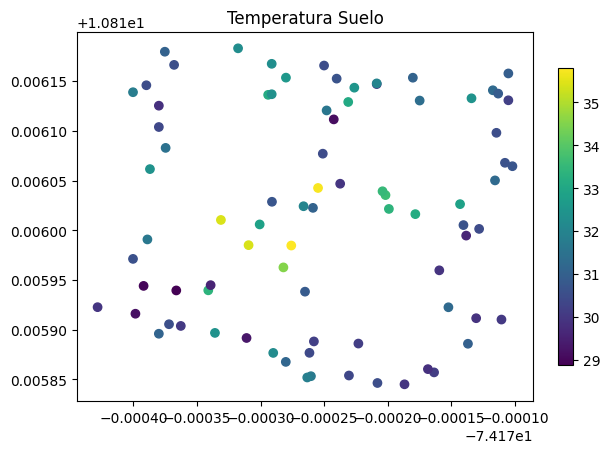

In [7]:
cax = plt.scatter(x, y, c=phi)
cbar = plt.colorbar(cax, fraction=0.03)
plt.title('Temperatura Suelo')


**Aplicando el método Kriging**

Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'hole-effect' Variogram Model
Partial Sill: 2.093418066052539
Full Sill: 2.093426385718599
Range: 0.00016035292595529565
Nugget: 8.319666059665576e-06 



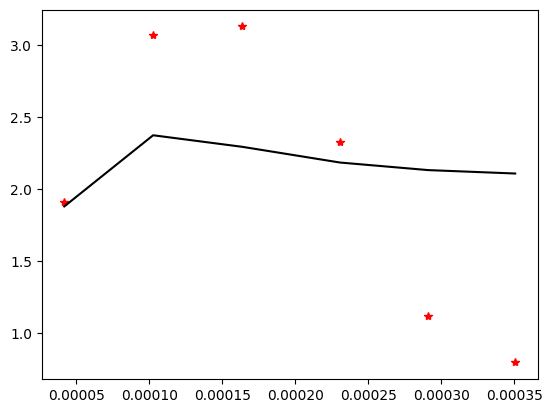

Calculating statistics on variogram model fit...


In [8]:
OK = OrdinaryKriging(
    x,
    y,
    phi,
    variogram_model="hole-effect",
    verbose=True,
    enable_plotting=True,
    coordinates_type='geographic',
    # nlags=30,
)


In [9]:
OK.variogram_model_parameters

array([2.09341807e+00, 1.60352926e-04, 8.31966606e-06])

In [32]:
# gridx = np.arange(-300, 300, 10, dtype='float64')
# gridy = np.arange(0, 600, 10, dtype='float64')
nx, ny = 100, 100
grid_x = np.linspace(min(x), max(x), nx)
grid_y = np.linspace(min(y), max(y), ny)
# zstar almacenará los valores interpolados y ss los valores de la varianza
zstar, ss = OK.execute("grid", grid_x, grid_y)

Executing Ordinary Kriging...



Invierte las filas de una matriz en el eje y. Es decir, invierte la orientación de los datos en el eje vertical de la matriz.
Esto se hace porque la matriz de datos de campo se lee de abajo hacia arriba, mientras que la matriz de datos de la imagen se lee de arriba hacia abajo.

In [11]:
zstar = np.flipud(zstar)

Text(0.5, 1.0, 'Temperatura del suelo')

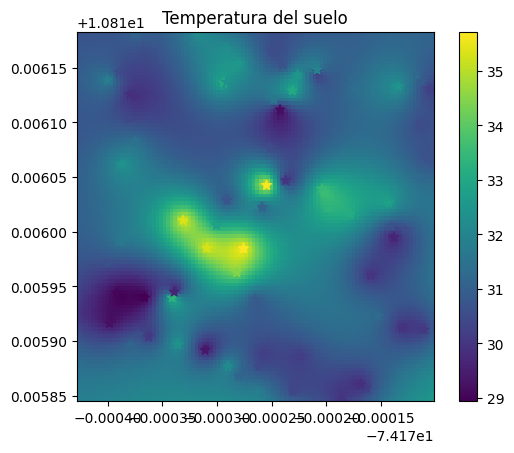

In [12]:
cax = plt.imshow(zstar, extent=(
    min(x), max(x), min(y), max(y)))
plt.scatter(x, y, c=phi, marker='*', s=50)
cbar = plt.colorbar(cax)
plt.title('Temperatura del suelo')


Text(0.5, 1.0, 'Desviación estándar')

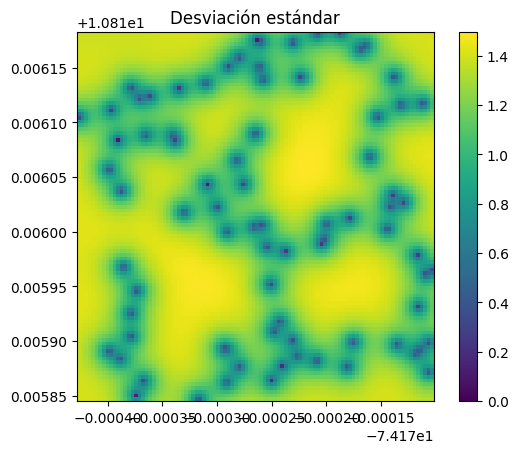

In [13]:
cax = plt.imshow(np.sqrt(ss), extent=(
    min(x), max(x), min(y), max(y)), vmin=0)
# plt.scatter(x, y, c='k', marker='.')
cbar = plt.colorbar(cax)
plt.title("Desviación estándar")


In [14]:
transform = rasterio.transform.from_bounds( 
    min(x), min(y), max(x), max(y), nx, ny)
transform


Affine(3.263999999916223e-06, 0.0, -74.17042819999999,
       0.0, -3.3800000000105966e-06, 10.816183)

Guardar el archivo tiff en la carpeta de trabajo

In [15]:
with rasterio.open(
    'data/kriging_export.tiff',
    'w',
    driver='GTiff',
    height=zstar.shape[0],
    width=zstar.shape[1],
    count=1,
    dtype=zstar.dtype,
    crs={"init": "epsg:4326"},
    transform=transform,
) as dst:
    dst.write(zstar, 1)


# Graficar en 3D

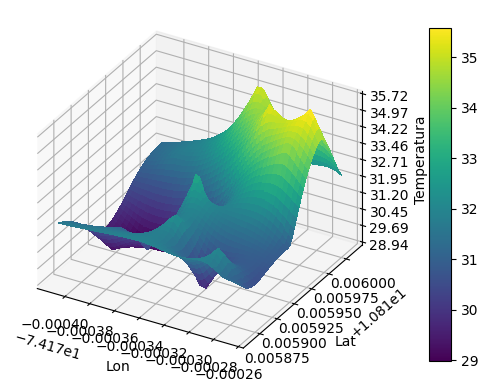

In [110]:
x = grid_x
y = grid_y
x, y = np.meshgrid(x, y)

z = zstar.data
region = np.s_[5:50, 5:50]
x, y, z = x[region], y[region], z[region]

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))


# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.viridis,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(z.min(), z.max())
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_proj_type('ortho')
ax.set_xlabel("Lon", labelpad=5)
ax.set_ylabel("Lat", labelpad=8)
ax.set_zlabel("Temperatura")
ax.set_zlim(z.min(), z.max())
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.9, aspect=15, pad=0.1)

plt.show()
